# SARS-COV-2 raðgreining
Elías Bjartur Einarsson - ebe19@hi.is <br>
Þórhallur Auður Helgason - thh114@hi.is

In [1]:

def parse_fasta(fn):
    with open(fn,'r') as f:
        line = f.readline()
        name = line[1:line.find(' ')].strip()
        seq = []
        while line:
            line = f.readline()
            seq.append(line.strip())
    return name,''.join(seq)
                

In [2]:
name,ref = parse_fasta('reference.fasta')

In [3]:
print(name,len(ref))

MN908947.3 29903


In [4]:
def parse_fastq(fn,limit=None):
    seqs = []
    with open(fn,'r') as f:
        i = 0
        while limit is None or i < limit:
            _ = f.readline()
            seq = f.readline().strip()
            _ = f.readline()
            _ = f.readline()
            seqs.append(seq)
            i += 1
    return seqs

In [5]:
Seqs = parse_fastq('SRR11397721_1.fastq', 1500000)

In [6]:
Seqs2 = parse_fastq('SRR11397721_2.fastq', 1500000)

In [7]:
d = dict(zip('ACGT', 'TGCA'))
def revComp(pattern):
    return ''.join(d[x] for x in pattern[::-1])

revcmp = lambda p: ''.join(d[s] for s in p[::-1])

In [8]:
def kmerDict(k, Text):
    n = len(Text)
    Kramer = {}
    for i in range(n-k+1):
        kmer = Text[i:i+k]
        if kmer in Kramer:
            Kramer[kmer].append(i)
        else:
            Kramer[kmer] = [i]
    return Kramer

def kmerList(k, Text):
    n = len(Text)
    Kramer = []
    for i in range(n-k+1):
        kmer = Text[i:i+k]
        Kramer.append(kmer)
    return Kramer

In [9]:
import json

Sars21dict = kmerDict(21, ref)

jsonDump = json.dumps(Sars21dict)
f = open("Sars21Dict.json","w")
f.write(jsonDump)
f.close()

In [10]:
def ham(a, b):
    n = len(a)
    m = len(b)
    if (n-m!=0): 
        print("mislöng")
    count = 0
    for i in range(n):
        if (a[i]!=b[i]):
            count += 1
    return count
        

In [11]:
import json

with open('Sars21Dict.json', 'r') as f:
    Dict21 = json.loads(f.read()) 


In [12]:
toIdx = dict(zip('-ACGT', range(5)))
toNt = dict(zip(range(5), '-ACGT'))

In [13]:
def Fitting(lest):
    Upphöf = {} # Þær staðsetningar í ref sem koma til greina fyrir þetta read (þessa lest)
    lestarListi = kmerList(21, lest) # Samsetning þessarar lestar í 21-merum
    # Finnum þá upphafstaði sem koma til greina
    for i, kmer in enumerate(lestarListi):
        if kmer in Dict21:
            for pos in Dict21[kmer]:
                #print(pos)
                if pos-i in Upphöf:
                    Upphöf[pos-i] += 1
                else:
                    Upphöf[pos-i] = 1
        # Athugum hvort reverse complement birtist, neikvæð stig til að halda utan um að hún sé öfug
        elif revComp(kmer) in Dict21:
            for pos in Dict21[revComp(kmer)]:
                #print(pos)
                if pos+i in Upphöf:
                    Upphöf[pos+i] += -1 
                else:
                    Upphöf[pos+i] = -1

        # Ef hvorugt finnst þá gerum við ekkert
         
    Lkmer = len(lest)-20
    # Hámarksfjöldi villna ef aðeins 1 mismatch er í lest og ekkert indel reiknast skv. þessari formúlu 
    # Ef villur fara yfir þennan þröskuld, er strax ljóst að villur eru 2+ eða indel kemur fyrir.
    # getur orðið meira en 100% fyrir mjög stutta strengi en skiptir ekki öllu
    Lthreshold = 21/Lkmer

    # Finnum þann upphafsstað sem oftast kemur fyrir. 
    #Notum tölugildi til að telja jafnt þær á réttunni og þær á röngunni
    maxInDict = 0
    Rev = False
    réttUpphaf = None
    for key, value in Upphöf.items():
        if abs(value) > maxInDict:
            maxInDict = abs(value)
            if value < 0:
                réttUpphaf = key - len(lest) + 21
                Rev = True
            else:
                réttUpphaf = key
    nonMatch = (1 - maxInDict)/Lkmer
    # sendum lest í local-alignment ef víst er að villur eru tvær eða indel hliðrun, miðum við þröskuldinn
    localAlign = (nonMatch > Lthreshold)

    return(réttUpphaf, Rev, localAlign)
        

In [14]:
def localAlignment(lest, comparison):
    m = len(lest)
    n = len(comparison)
    sigma = 1
    matrix = np.zeros((n+1, m+1), dtype=int)
    backtrack = np.zeros((n+1, m+1), dtype=int)
    taxiBack = False
    for i in range(1, n+1):
        for j in range(1, m+1):
            diag = matrix[i-1, j-1] + int(lest[j-1]==comparison[i-1])
            down = matrix[i-1, j]
            right = matrix[i, j-1]
            # Ef síðasta stak þá bjóðum við upp á ókeypis ferð frá hæsta gildi 
            # fylkisins þangað og höldum utan um hvaðan það kemur
            if j == m and i == n:
                _max = np.amax(matrix)
                
                if _max == max([diag, down, right, 0, _max]):
                    taxiBack = True
                    departure = np.where(matrix == np.amax(matrix)) 
                    matrix[i, j] = _max
                    backtrack[i, j] = 10 
                else:
                    matrix[i, j] = max([diag, down, right, 0])
                    if matrix[i,j] == down: 
                        backtrack[i, j] = 1
                    elif matrix[i, j] == right: 
                        backtrack[i, j] = 2
                    elif matrix[i, j] == diag:
                        backtrack[i, j] = 3
                    elif matrix[i, j] == 0:
                        backtrack[i, j] = 0
            else:
                matrix[i, j] = max([diag, down, right, 0])

                if matrix[i,j] == down: 
                    backtrack[i, j] = 1
                elif matrix[i, j] == right: 
                    backtrack[i, j] = 2
                elif matrix[i, j] == diag:
                    backtrack[i, j] = 3
                elif matrix[i, j] == 0:
                    backtrack[i, j] = 0
    
    stig = int(matrix[n, m])
    if taxiBack:
        i = int(departure[0])
        j = int(departure[1])
    else: # þegar satt
        i = n
        j = m
    efri = []
    neðri = []
    while backtrack[i, j] != 0:
        if backtrack[i, j] == 1:
            # Við viljum ekki að reference strengur geti stækkað
            # fengum að vita í verkefninu að consensus-strengur ætti ekki að byggja á slíku, svo þetta er í lagi
            i -= 1
        elif backtrack[i, j] == 2:
            efri.append(lest[j-1])
            neðri.append('-')
            j -= 1
        else:
            efri.append(lest[j-1])
            neðri.append(comparison[i-1])
            i -=1
            j -= 1
    efri.reverse()
    neðri.reverse()
    
    return ''.join(efri), ''.join(neðri)

In [15]:
import numpy as np
def CntMatrix(seqs):
    # uppfæra CountMatrix m.t.t. gata
    CountMatrix = np.zeros((5, len(ref)), dtype=int)

    for lestanumer, lest in enumerate(seqs):
        if lestanumer % (len(seqs)//10) == 0: # Eina þörfin fyrir lestanumer akkúrat núna
            print('lestarvagn ' + str(lestanumer))
        réttUpphaf, Rev, localAlign = Fitting(lest)
        if réttUpphaf == None: # Kmerar lestarinnar ekki að finna. Kannski mjög stutt með villu
            continue
        
        # snýr lestin öfugt?
        if Rev:
            lest = revComp(lest)
            
        # ef lestin var lesin öfugt niður og hefur indel, gæti hún hafa farið yfir upphafið. Hliðrum því.
        if réttUpphaf < 0:
            lest = lest[abs(réttUpphaf):]
            réttUpphaf = 0
            
        # skoða hvort þurfi að laga með local alignment
        if localAlign:
            comparison = ref[réttUpphaf:réttUpphaf + len(lest) + 6] # 6 er handvalinn buffer hér fyrir local alignment
            lest, alignedRef = localAlignment(lest, comparison)
        
        # uppfæra count matrix út frá lestinni
        for idx, nt in enumerate(lest):
            if réttUpphaf + idx == CountMatrix.shape[1]: 
            #ef indel eða staðsetning lestar valda því að við förum út fyrir ref; hætta en geyma það sem var komið
                break
            CountMatrix[toIdx[nt], réttUpphaf + idx] += 1


    print('Endastöð. Please mind the gap.')
    return CountMatrix

In [16]:
import matplotlib.pyplot as plt
np.seterr(divide='ignore', invalid='ignore')

def Sequencer(n_reads, ref): # n_reads er fjöldi lestra úr hvoru safninu -> tvöfalt magn skoðað
    seqs = Seqs[:n_reads]+Seqs2[:n_reads]
    ProfileMatrix = CntMatrix(seqs)
    ConsensusBase = np.argmax(ProfileMatrix, axis=0)
    Consensus = []
    for base in ConsensusBase:
        Consensus.append(toNt[base])
    HammingDistance = ham(ref, Consensus)
    
    Depth = np.sum(ProfileMatrix, axis=0)
    Score = np.amax(ProfileMatrix, axis=0)
    Quality = Score/Depth
    StartCut = 0
    while Depth[StartCut] < 100:
        StartCut += 1
    EndCut = len(ref)-1
    while Depth[EndCut] < 100:
        EndCut += -1
    InternalHamming = ham(ref[StartCut:EndCut], Consensus[StartCut:EndCut])
    
    fig, axs = plt.subplots(2, 1, constrained_layout=True)
    axs[0].plot(range(len(Depth)), Depth)
    axs[0].set_title('Depth of Sequencing')
    axs[0].set_xlabel('Location')
    axs[0].set_ylabel('Depth')
    fig.suptitle('Reliability of Consensus String', fontsize=16)

    axs[1].plot(range(len(Quality)), Quality)
    axs[1].set_title('Ratio for consensus')
    axs[1].set_xlabel('Location')
    axs[1].set_ylabel('Ratio')
    
    plt.show()
    #plt.savefig('Reliability.jpeg', quality = 95, transparent = True, dpi = 'figure', optimize = True)

    print('\n')
    print('Total Hamming distance between reference and consensus string: ', HammingDistance, '\n')
    print('Hamming distance ignoring unreliable regions at beginning and end of string: ', InternalHamming, '\n')
    print('Average depth of sequencing: ', int(round(np.sum(Depth,axis=0)/len(ref))), '\n')
    print('Beginning region unreliable (depth < 100) for first ', StartCut, ' basepairs.', '\n')
    print('Ending region unreliable (depth < 100) for last ', (len(ref)-EndCut), ' basepairs.', '\n')
    print('Variations between reference and consensus string:', '\n')
    for i in range(StartCut,EndCut):
        if ref[i] != Consensus[i]:
            print('Location ', i+1, ': ', ref[i], ' (reference) to ', Consensus[i], ' (consensus) with ', '{:04.1f}'.format(100*Quality[i]), '% vote' '\n')
    return(Consensus, ProfileMatrix)

lestarvagn 0
lestarvagn 180000
lestarvagn 360000
lestarvagn 540000
lestarvagn 720000
lestarvagn 900000
lestarvagn 1080000
lestarvagn 1260000
lestarvagn 1440000
lestarvagn 1620000
Endastöð. Please mind the gap.


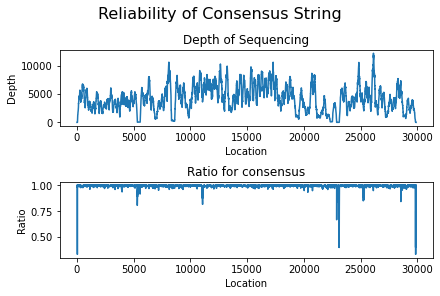



Total Hamming distance between reference and consensus string:  49 

Hamming distance ignoring unreliable regions at beginning and end of string:  9 

Average depth of sequencing:  4231 

Beginning region unreliable (depth < 100) for first  39  basepairs. 

Ending region unreliable (depth < 100) for last  53  basepairs. 

Variations between reference and consensus string: 

Location  884 :  C  (reference) to  T  (consensus) with  99.6 % vote

Location  1397 :  G  (reference) to  A  (consensus) with  99.4 % vote

Location  8653 :  G  (reference) to  T  (consensus) with  99.0 % vote

Location  11083 :  G  (reference) to  T  (consensus) with  98.1 % vote

Location  12357 :  C  (reference) to  T  (consensus) with  99.6 % vote

Location  13506 :  C  (reference) to  T  (consensus) with  98.8 % vote

Location  26447 :  C  (reference) to  T  (consensus) with  99.7 % vote

Location  28688 :  T  (reference) to  C  (consensus) with  95.2 % vote

Location  29742 :  G  (reference) to  T  (consens

In [19]:
BigConString, BigProfile = Sequencer(900000,ref)

In [33]:
import csv

with open('Sars-Cov-2.csv', mode='w') as csv_file:
    fieldnames = ['POSITION', 'REFERENCE', 'ALTERNATIVE']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames, delimiter='\t')
    writer.writeheader()
    for i in range(39,len(ref)-53):
        if ref[i] != BigConString[i]:
            writer.writerow({'POSITION': i+1, 'REFERENCE': ref[i], 'ALTERNATIVE': BigConString[i]})


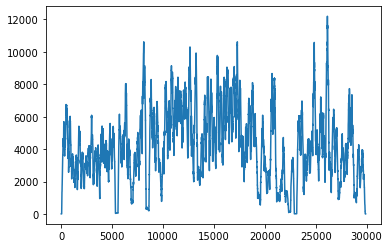

In [23]:
import warnings
warnings.simplefilter('ignore')

depth = np.sum(BigProfile, axis=0)
import matplotlib.pyplot as plt
plt.plot(range(len(depth)), depth)
plt.show
plt.savefig('DepthOfSequencing.jpeg', quality = 95, transparent = True, dpi = 'figure', optimize = True)

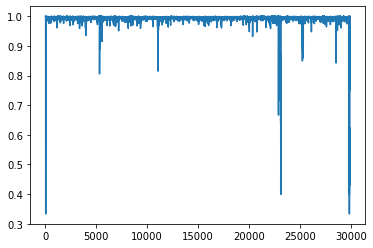

In [24]:
score = np.amax(BigProfile, axis=0)
consensus = score/depth
import matplotlib.pyplot as plt
plt.plot(range(len(consensus)), consensus)
plt.show
plt.savefig('SequencingConsensus.jpeg', quality = 95, transparent = True, dpi = 'figure', optimize = True)